## Q-Learning



Q-learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. It does not require a model of the environment (hence "model-free"), and it can handle problems with stochastic transitions and rewards without requiring adaptations.

For any finite Markov decision process (FMDP), Q-learning finds an optimal policy in the sense of maximizing the expected value of the total reward over any and all successive steps, starting from the current state.[1] Q-learning can identify an optimal action-selection policy for any given FMDP, given infinite exploration time and a partly-random policy.[1] "Q" refers to the function that the algorithm computes – the expected rewards for an action taken in a given state.[2]

Reinforcement Learning (RL) is one of the learning paradigms in machine learning that learns an optimal policy mapping states to actions by interacting with an environment to achieve the goal. In this article, I will introduce the two most commonly used RL algorithm: Q-Learning and SARSA.
Similar to the Monte Carlo Algorithm (MC), Q-Learning and SARSA algorithms are also model-free RL algorithms that do not use the transition probability distribution associated with Markov Decision Process (MDP). Instead, they learn the optimal policy from experience. The main difference between MC and Q-Learning or SARSA algorithm is that MC needs to sample…

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tf.compat.v1.disable_eager_execution()
sns.set()

In [2]:
df = pd.read_csv('/Users/gkumargaur/workspace/python/gitprojects/Stock-Prediction-Models/dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2020-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2020-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2020-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2020-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.compat.v1.reset_default_graph()
        self.sess = tf.compat.v1.InteractiveSession()
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])
        feed = tf.compat.v1.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.compat.v1.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))


            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest,
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/gkumargaur/opt/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 438.999761.3, cost: 1.912567, total money: 10438.999761
epoch: 20, total rewards: 398.874943.3, cost: 0.604044, total money: 10398.874943
epoch: 30, total rewards: 323.404912.3, cost: 0.290055, total money: 10323.404912
epoch: 40, total rewards: 454.614873.3, cost: 0.222459, total money: 10454.614873
epoch: 50, total rewards: 455.604863.3, cost: 0.177244, total money: 10455.604863
epoch: 60, total rewards: 429.334904.3, cost: 0.128823, total money: 10429.334904
epoch: 70, total rewards: 417.804875.3, cost: 0.404543, total money: 10417.804875
epoch: 80, total rewards: 370.074895.3, cost: 0.094437, total money: 10370.074895
epoch: 90, total rewards: 452.754888.3, cost: 0.081636, total money: 10452.754888
epoch: 100, total rewards: 479.614874.3, cost: 0.070567, total money: 10479.614874
epoch: 110, total rewards: 363.474919.3, cost: 0.061853, total money: 10363.474919
epoch: 120, total rewards: 328.994878.3, cost: 0.057692, total money: 10328.994878
epoch: 130, t

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 3: buy 1 unit at price 782.520020, total balance 9217.479980
day 4, sell 1 unit at price 790.510010, investment 1.021059 %, total balance 10007.989990,
day 6: buy 1 unit at price 762.559998, total balance 9245.429992
day 7: buy 1 unit at price 754.020020, total balance 8491.409972
day 9: buy 1 unit at price 758.489990, total balance 7732.919982
day 10: buy 1 unit at price 764.479980, total balance 6968.440002
day 11, sell 1 unit at price 771.229980, investment 1.136957 %, total balance 7739.669982,
day 12, sell 1 unit at price 760.539978, investment 0.864693 %, total balance 8500.209960,
day 15: buy 1 unit at price 760.989990, total balance 7739.219970
day 17: buy 1 unit at price 768.239990, total balance 6970.979980
day 19, sell 1 unit at price 758.039978, investment -0.059330 %, total balance 7729.019958,
day 20: buy 1 unit at price 747.919983, total balance 6981.099975
day 21: buy 1 unit at price 750.500000, total balance 6230.599975
day 22, sell 1 unit at price 762.520020, inve

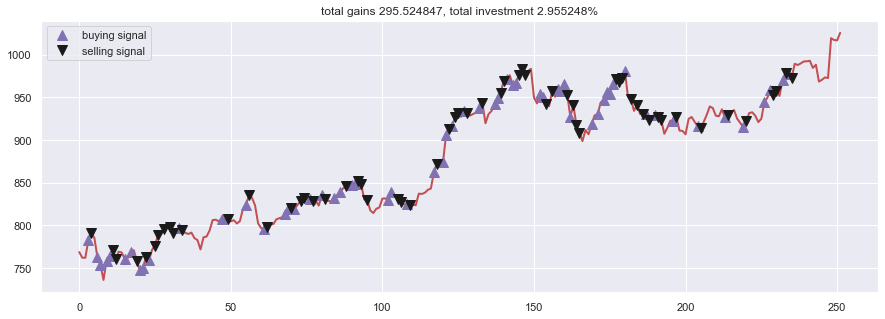

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()